In [24]:
from dotenv import load_dotenv
import os
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from joblib import dump, load
local_path = "/home/lucas/zrive-ds/data/module_3/feature_frame.csv"

In [3]:
load_dotenv()
session = boto3.Session(
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
)

s3 = session.client("s3")

bucket_name = "zrive-ds-data"
path = "groceries/box_builder_dataset/feature_frame.csv"

try:
    s3.download_file(bucket_name, path, local_path)
    print(f"File downloaded succesfully.")
except Exception as e:
    print(f"File not found : {e}")

File downloaded succesfully.


List with numeric and categorical columns are defined.

In [25]:
numeric_cols = ['user_order_seq',
                'ordered_before',
                'abandoned_before',
                'active_snoozed',
                'set_as_regular',
                'normalised_price',
                'discount_pct',
                'global_popularity',
                'count_adults',
                'count_children',
                'count_babies',
                'count_pets',
                'people_ex_baby',
                'days_since_purchase_variant_id',
                'avg_days_to_buy_variant_id',
                'std_days_to_buy_variant_id',
                'days_since_purchase_product_type',
                'avg_days_to_buy_product_type',
                'std_days_to_buy_product_type'
                ]
categorical_cols = ['vendor',
                    'order_date',
                    'created_at',
                    'product_type']

Since it is a constraint, orders with 5 products or more are selected from the complete dataset.

In [26]:
dataset = pd.read_csv(local_path)

orders = dataset[dataset['outcome'] == 1]

order_sizes = orders.groupby('order_id').size()

large_orders = order_sizes[order_sizes >= 5].index

selected_orders = dataset[dataset['order_id'].isin(large_orders)]

selected_orders.head(20)

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
6,33826472919172,ricepastapulses,2808548917380,3476645445764,2020-10-06 14:23:08,2020-10-06 00:00:00,5,0.0,1.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
7,33826472919172,ricepastapulses,2808549900420,3437017956484,2020-10-06 14:24:26,2020-10-06 00:00:00,13,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
9,33826472919172,ricepastapulses,2808728715396,3421126885508,2020-10-06 19:36:06,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
10,33826472919172,ricepastapulses,2808769085572,3442602868868,2020-10-06 20:45:38,2020-10-06 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
11,33826472919172,ricepastapulses,2808786714756,3486509793412,2020-10-06 21:19:13,2020-10-06 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


Variables weekday and time_of_day are created as it is considered that can add valuable information to the model.

In [27]:
selected_orders['created_at'] = pd.to_datetime(selected_orders['created_at'])
selected_orders['weekday'] = selected_orders['created_at'].dt.dayofweek
categorical_cols.append('weekday')

/tmp/ipykernel_13891/2781777034.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_orders['created_at'] = pd.to_datetime(selected_orders['created_at'])
/tmp/ipykernel_13891/2781777034.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_orders['weekday'] = selected_orders['created_at'].dt.dayofweek


In [28]:
selected_orders['hour'] = selected_orders['created_at'].dt.hour

def get_time_of_day(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 22:
        return 'evening'
    else:
        return 'night'

selected_orders['time_of_day'] = selected_orders['hour'].apply(get_time_of_day)
categorical_cols.append('time_of_day')
selected_orders.drop('hour', axis=1, inplace=True)


/tmp/ipykernel_13891/278257896.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_orders['hour'] = selected_orders['created_at'].dt.hour
/tmp/ipykernel_13891/278257896.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_orders['time_of_day'] = selected_orders['hour'].apply(get_time_of_day)
/tmp/ipykernel_13891/278257896.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [29]:
selected_orders.sort_values('order_id').head(30)

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,weekday,time_of_day
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.276180,0,afternoon
481583,33973246853252,tinspackagedfoods,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,2.0,33.0,30.0,30.234265,30.0,27.0,23.827826,0,afternoon
2398555,33667228663940,wipescottonwool,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,2.0,33.0,41.5,28.238356,30.0,34.0,27.826713,0,afternoon
478137,33863279214724,bathshowergel,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,2.0,33.0,54.0,35.319072,30.0,37.0,30.506129,0,afternoon
2402001,33826467152004,superfoodssupplements,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,2.0,33.0,55.0,34.085746,30.0,37.0,27.032264,0,afternoon
474691,33803543347332,foodstorage,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,2.0,33.0,14.0,3.532165,30.0,37.5,30.498356,0,afternoon
2405807,33826458337412,superfoodssupplements,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,2.0,33.0,32.0,23.810595,30.0,37.0,27.032264,0,afternoon
471245,34173018734724,homebaking,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,2.0,33.0,34.5,32.267135,30.0,28.5,23.710730,0,afternoon
467799,33824368033924,washingpowder,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,2.0,33.0,30.5,28.724102,30.0,37.0,29.593617,0,afternoon
2413965,33667293085828,juicesquash,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,2.0,33.0,34.0,27.693045,30.0,27.0,25.876853,0,afternoon


As we saw in eda module, 'days_since_purchase' varibles shows a strange pattern, so they will be eliminated.
Similar for count variables.

In [30]:
to_drop_columns = ['days_since_purchase_variant_id',
                      'days_since_purchase_product_type',
                      'count_adults',
                      'count_children',
                      'count_babies',
                      'count_pets',
                      'people_ex_baby',
                      ]

for item in to_drop_columns:
    if item in numeric_cols:
        numeric_cols.remove(item)

selected_orders.head(20)

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,weekday,time_of_day
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,0,afternoon
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,0,evening
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,0,evening
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,1,morning
5,33826472919172,ricepastapulses,2808434524292,3479090790532,2020-10-06 10:50:23,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,1,morning
6,33826472919172,ricepastapulses,2808548917380,3476645445764,2020-10-06 14:23:08,2020-10-06 00:00:00,5,0.0,1.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,1,afternoon
7,33826472919172,ricepastapulses,2808549900420,3437017956484,2020-10-06 14:24:26,2020-10-06 00:00:00,13,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,1,afternoon
9,33826472919172,ricepastapulses,2808728715396,3421126885508,2020-10-06 19:36:06,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,1,evening
10,33826472919172,ricepastapulses,2808769085572,3442602868868,2020-10-06 20:45:38,2020-10-06 00:00:00,4,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,1,evening
11,33826472919172,ricepastapulses,2808786714756,3486509793412,2020-10-06 21:19:13,2020-10-06 00:00:00,4,0.0,0.0,0.0,...,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618,1,evening


Train, validation and test split is done (70%, 10% and 20% of the original dataset).

In [31]:
from sklearn.model_selection import train_test_split

X = selected_orders.drop('outcome', axis=1)

y = selected_orders['outcome']

X_temp, X_test, y_temp, y_test = train_test_split(X,y, test_size=0.2, random_state = 42)

X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp, test_size=0.08, random_state=42)


Frequency encoding is done in variables 'product_type', 'type_of_day' and 'vendor'.

In [32]:
def frequency_encoding(
    column: str,
    column_list: list = categorical_cols
):
    freq_encoding = X_train[column].value_counts(normalize=True)

    X_train[column + '_freq'] = X_train[column].map(freq_encoding)

    X_test[column + '_freq'] = X_test[column].map(freq_encoding)

    X_val[column + '_freq'] = X_val[column].map(freq_encoding)

    column_list.append(column + '_freq')
    column_list.remove(column)
    return column_list


In [33]:
categorical_cols = frequency_encoding('product_type')
categorical_cols = frequency_encoding('time_of_day')
categorical_cols = frequency_encoding('vendor')


In [34]:
X_train[categorical_cols].head(15)

,order_date,created_at,weekday,product_type_freq,time_of_day_freq,vendor_freq
1341743,2021-02-09 00:00:00,2021-02-09 11:59:14,1,0.022621,0.280259,0.002386
843106,2021-01-14 00:00:00,2021-01-14 12:35:14,3,0.017842,0.340043,0.002214
726000,2020-11-10 00:00:00,2020-11-10 00:29:46,1,0.028911,0.081908,0.027671
708552,2020-10-16 00:00:00,2020-10-16 18:11:06,4,0.015589,0.297789,0.023841
2822095,2021-02-26 00:00:00,2021-02-26 17:32:41,4,0.038452,0.297789,0.002412
1538886,2020-12-20 00:00:00,2020-12-20 22:41:36,6,0.006634,0.081908,0.004221
1476934,2021-03-02 00:00:00,2021-03-02 21:07:11,1,0.038452,0.297789,0.013165
663747,2020-11-04 00:00:00,2020-11-04 08:54:58,2,0.040188,0.280259,0.002444
1683340,2020-12-29 00:00:00,2020-12-29 18:14:39,1,0.025216,0.297789,0.026145
883035,2020-12-03 00:00:00,2020-12-03 12:58:53,3,0.019948,0.340043,0.027671


Diffent settings for logistic regression are defined in order to be tested.

In [15]:
models = {}

for reg in ['l1', 'l2']:
    for c in [0.1, 1, 10]:
        model = LogisticRegression(penalty=reg, C=c, random_state=42,solver='liblinear')
        models[reg+' '+str(c)] = model

Different functions are defined to train models and evaluate it.

In [16]:
def fit_and_prediction(
    model: LogisticRegression,
    X_train: pd.DataFrame,
    y_train: pd.Series,
    X_val: pd.DataFrame,
    val_test: str
):
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    if val_test == 'test':
        return y_pred, model
    else:
        return y_pred

def curves_computation(
    y_pred,
    y_val: pd.Series,
    ax1,
    ax2,
    name
):
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    
    precision, recall, _ = precision_recall_curve(y_val, y_pred)
    pr_auc = auc(recall, precision)

    ax1.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')
    
    ax2.plot(recall, precision, lw=2, label=f'{name} (AUC = {pr_auc:.2f})')
    
    return ax1, ax2
    

In [17]:
def paint_graphics(cols:list, val_test: str = 'val'):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot([0, 1], [0, 1], 'k--', label='Random baseline')
    for name, model in models.items():
        if val_test == 'test':
            y_pred, model = fit_and_prediction(model,X_train[cols],y_train,X_test[cols],val_test)
            ax1, ax2 = curves_computation(y_pred,y_test, ax1, ax2, name)
        else:
            y_pred = fit_and_prediction(model,X_train[cols],y_train,X_val[cols], val_test)
            ax1, ax2 = curves_computation(y_pred,y_val, ax1, ax2, name)
        
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curves Comparison')
    ax1.legend(loc='lower right')
    ax1.grid(True)

    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curves Comparison')
    ax2.legend(loc='lower left')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    if val_test == 'test':
        return model

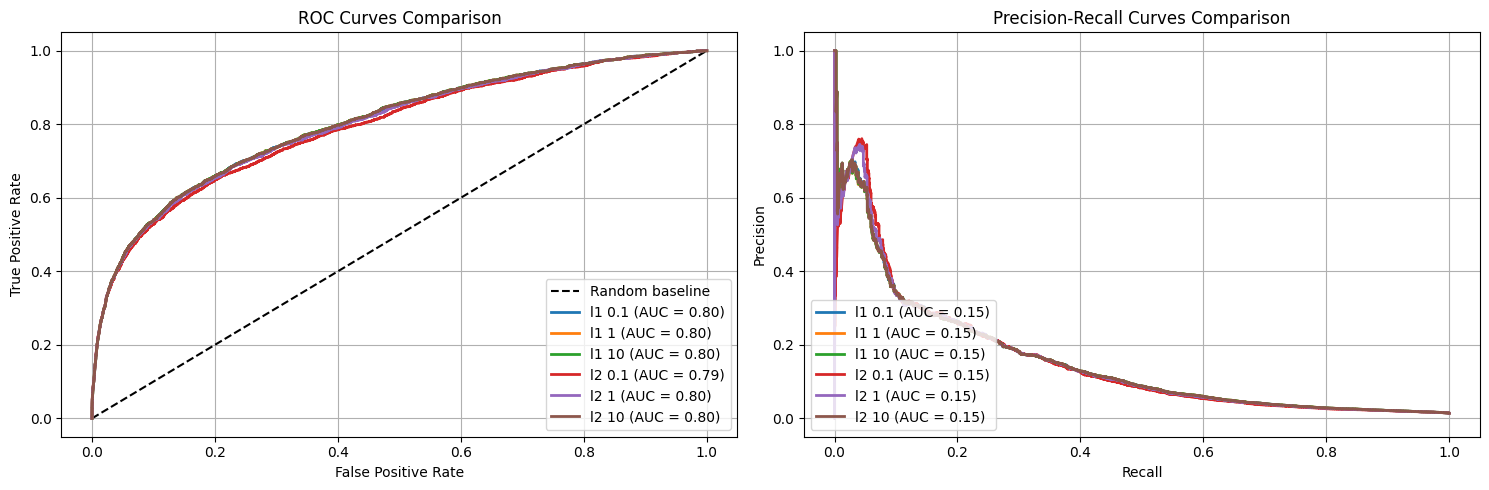

In [18]:
paint_graphics(numeric_cols)

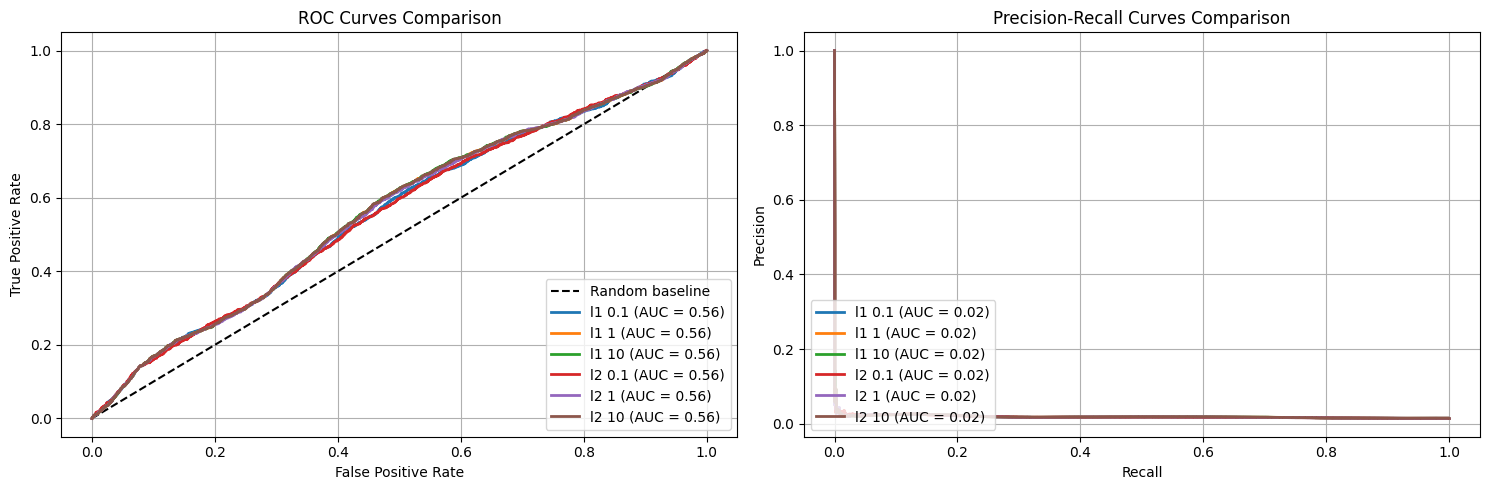

In [19]:
paint_graphics(categorical_cols)

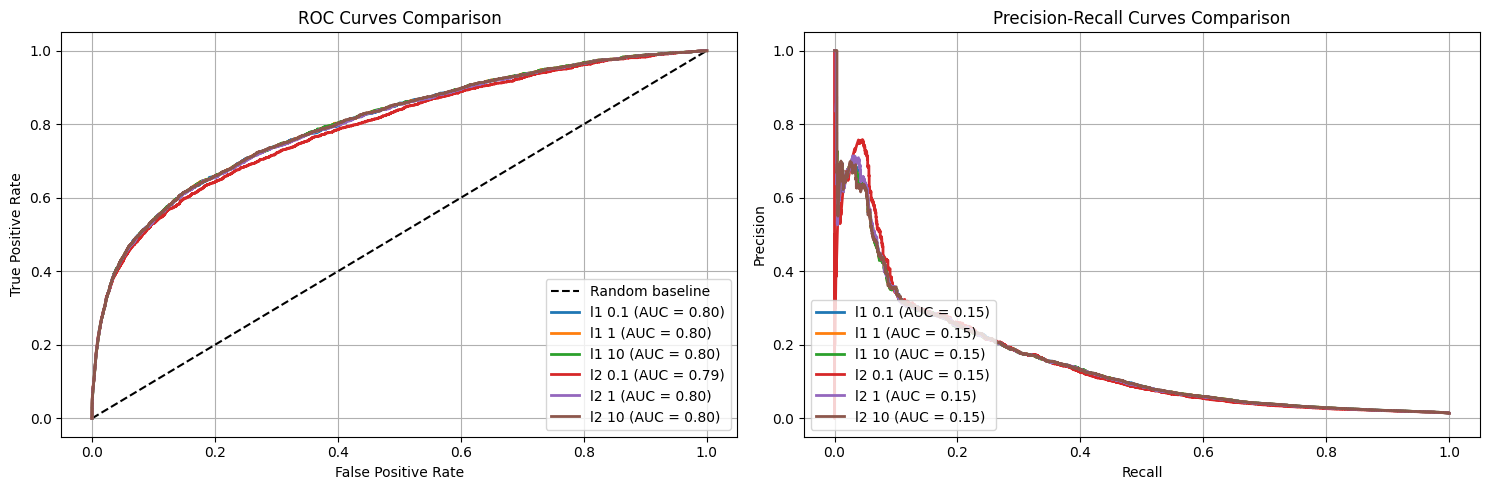

In [20]:
paint_graphics(numeric_cols+categorical_cols)

Evaluation of models with numeric and categorical columns separately and combinated gives as a result that model performs better with numerical columns. Among the different combinations of hyperparameters results are pretty similar. So the selected model is l1 regularization with C = 1 and is retrained and evaluated with test data. 

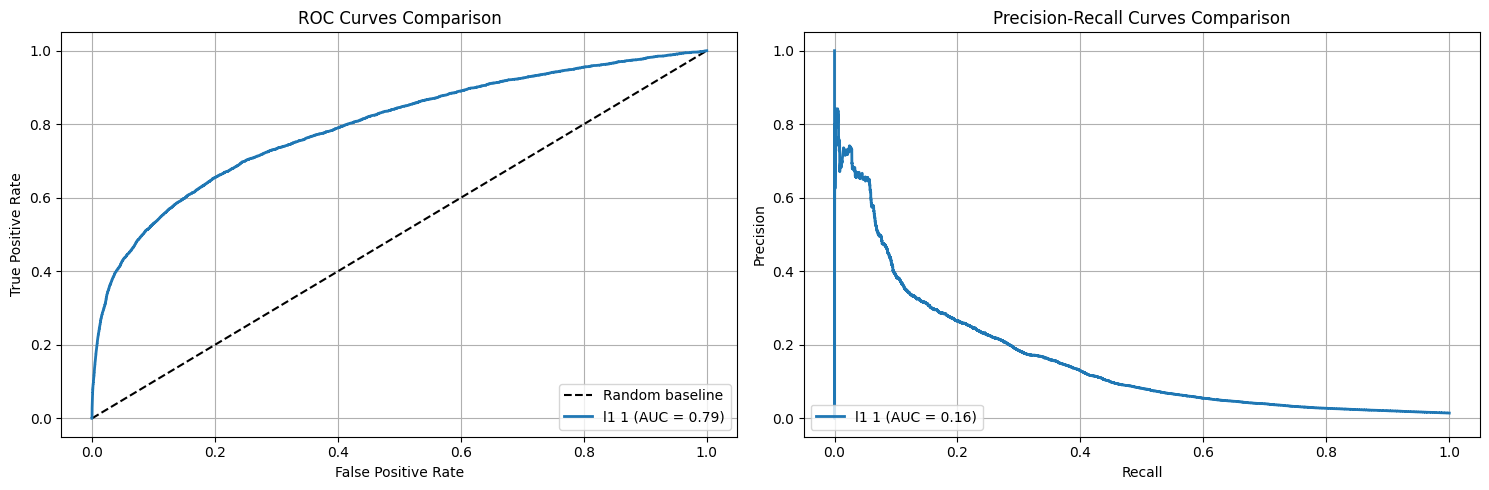

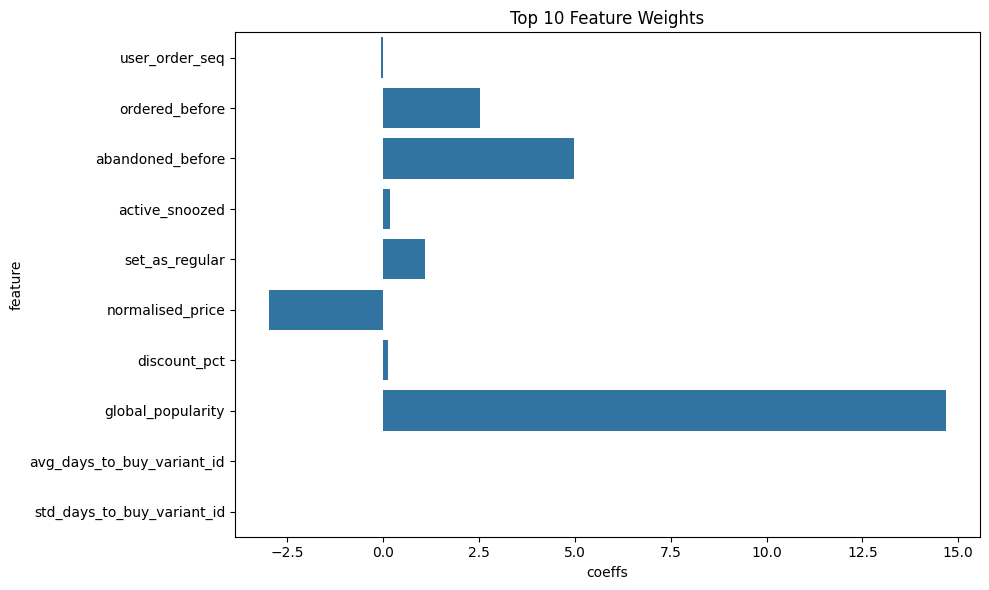

['/home/lucas/zrive-ds/models/module_3/regressionmodel.joblib']

In [37]:
models = {}
model = LogisticRegression(penalty=reg, C=c, random_state=42,solver='liblinear')
models['l1 1'] = model
model = paint_graphics(numeric_cols, 'test')
weights = {
    'feature':numeric_cols,
    'coeffs':model.coef_[0]
}
weights = pd.DataFrame(weights)

plt.figure(figsize=(10, 6))
sns.barplot(data=weights.head(10), x='coeffs', y='feature')
plt.title('Top 10 Feature Weights')
plt.tight_layout()
plt.show()

dump(model, '/home/lucas/zrive-ds/models/module_3/regressionmodel.joblib')